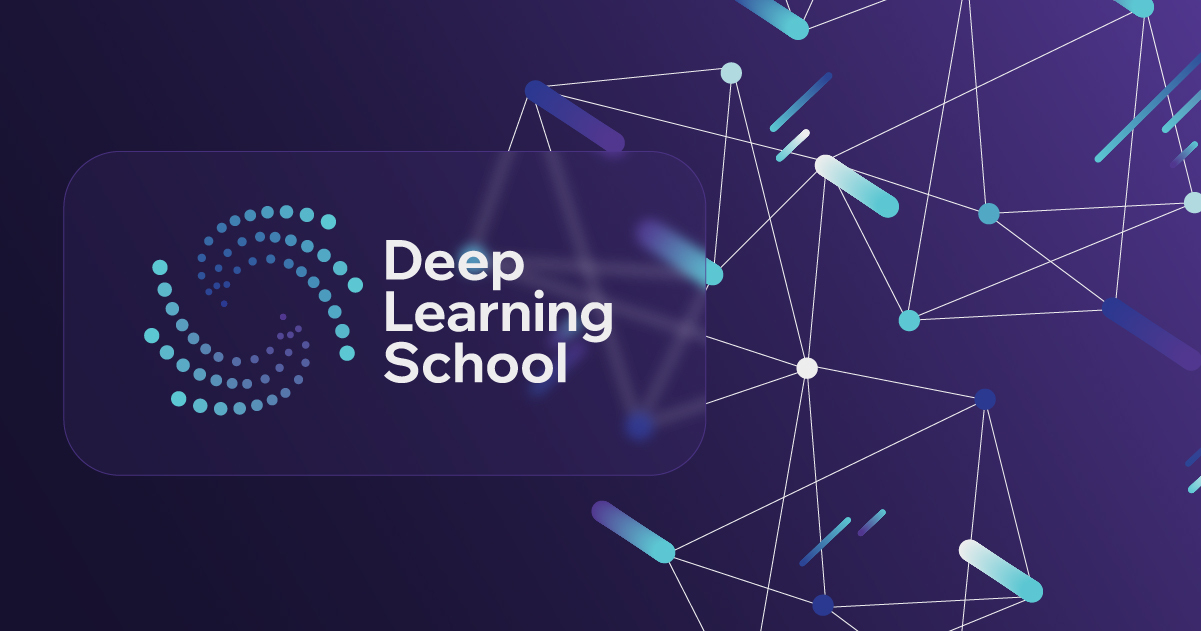


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr 14 13:52:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [5]:
!python --version

Python 3.11.11


In [6]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
tqdm version: 4.67.1
matplotlib version: 3.7.5
seaborn version: 0.12.2
Pillow version: 11.1.0


#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


# На протяжении ноутбука вы увидите такие эмодзи, если можно их так назвать: ✅, 📈, 💾, 🏁

решил их добавить, чтобы приятнее смотрелось)




# Обработка данных 
Проводим подсчёт количества меток каждого класса, чтобы понять, нужно ли делать аугментацию

In [10]:
from collections import Counter
import os

data_dir = "/kaggle/input/simpson-for-dls/simpsons_dataset/simpsons_dataset/"
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in os.listdir(data_dir)}
print(class_counts)


{'rainier_wolfcastle': 45, 'maggie_simpson': 128, 'krusty_the_clown': 1206, 'waylon_smithers': 181, 'professor_john_frink': 65, 'fat_tony': 27, 'ralph_wiggum': 89, 'otto_mann': 32, 'martin_prince': 71, 'barney_gumble': 106, 'ned_flanders': 1454, 'patty_bouvier': 72, 'sideshow_mel': 40, 'marge_simpson': 1291, 'abraham_grampa_simpson': 913, 'selma_bouvier': 103, 'mayor_quimby': 246, 'disco_stu': 8, 'lionel_hutz': 3, 'troy_mcclure': 8, 'agnes_skinner': 42, 'groundskeeper_willie': 121, 'kent_brockman': 498, 'charles_montgomery_burns': 1193, 'carl_carlson': 98, 'chief_wiggum': 986, 'apu_nahasapeemapetilon': 623, 'bart_simpson': 1342, 'edna_krabappel': 457, 'gil': 27, 'comic_book_guy': 469, 'principal_skinner': 1194, 'cletus_spuckler': 47, 'milhouse_van_houten': 1079, 'snake_jailbird': 55, 'nelson_muntz': 358, 'lisa_simpson': 1354, 'lenny_leonard': 310, 'moe_szyslak': 1452, 'miss_hoover': 17, 'homer_simpson': 2246, 'sideshow_bob': 877}


видимо очень сильный дисбаланс, соответственно нет смысла дополнять его до макс. значения, имеет смысл поставить порог для каждого - 1000 и проредить те, которые больше, дополнив с помощью ImageDataGenerator те, в которых меньше

функция для обработки классов, как было описано выше

In [11]:
import os
import random
from shutil import copyfile
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

SOURCE_DIR = data_dir
TARGET_DIR = "/kaggle/working/balanced_dataset"
TARGET_COUNT = 1000 


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


def balance_class(class_name):
    src_class_dir = os.path.join(SOURCE_DIR, class_name)
    dst_class_dir = os.path.join(TARGET_DIR, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.png'))]
    n = len(images)

    # копируем все, если ровно столько
    if n == TARGET_COUNT:
        for fname in images:
            copyfile(os.path.join(src_class_dir, fname), os.path.join(dst_class_dir, fname))

    # проредить 
    elif n > TARGET_COUNT:
        selected = random.sample(images, TARGET_COUNT)
        for fname in selected:
            copyfile(os.path.join(src_class_dir, fname), os.path.join(dst_class_dir, fname))

    # дополнить
    else:
        for fname in images:
            copyfile(os.path.join(src_class_dir, fname), os.path.join(dst_class_dir, fname))

        i = 0
        while n + i < TARGET_COUNT:
            fname = images[i % n]
            img_path = os.path.join(src_class_dir, fname)
            try:
                img = load_img(img_path)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                aug_img = next(datagen.flow(x, batch_size=1))[0].astype('uint8')
                save_img(os.path.join(dst_class_dir, f"aug_{i}.jpg"), aug_img)
                i += 1
            except Exception as e:
                print(f"[!] Ошибка с файлом {img_path}: {e}")
                i += 1

all_classes = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]

for cls in tqdm(all_classes, desc="Balancing classes"):
    balance_class(cls)

print("✅ Датасет сбалансирован и сохранён в:", TARGET_DIR)

2025-04-14 13:52:43.794525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744638764.018573      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744638764.085666      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Balancing classes: 100%|██████████| 42/42 [17:11<00:00, 24.55s/it]

✅ Датасет сбалансирован и сохранён в: /kaggle/working/balanced_dataset


# Построение нейросети
я решил сделать на основе ResNet50, как из советов в конце базового ноутбука, а так же использовать AdamW.

Так же надо дообучить её, тк я пробовал без дообучения, и получалось очень плохо

И я решил использовать взвешенную функцию потерь, тк датасет был несбалансирован

и так же добавил усиленную трансформацию картинок для аугментации

#### Модель

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import os

DATA_DIR = '/kaggle/working/balanced_dataset'
BATCH_SIZE = 32
NUM_EPOCHS = 15
NUM_CLASSES = 42
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = 'best_model.pt'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(DEVICE)

labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

In [13]:
best_f1 = 0.0

def train_model():
    global best_f1
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total * 100
        print(f"\n✅ Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Accuracy: {acc:.2f}%")

        val_f1 = validate_f1()
        scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"💾 Saved best model with F1 = {val_f1:.4f}")

def validate_f1():
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"📈 Validation F1-score: {f1:.4f}")
    return f1


In [14]:
train_model()
print(f"\n🏁 Лучшая F1: {best_f1:.4f} | Модель сохранена в: {BEST_MODEL_PATH}")

Epoch 1/15: 100%|██████████| 1050/1050 [06:29<00:00,  2.69it/s]



✅ Epoch 1 | Train Loss: 668.7492, Accuracy: 85.49%
📈 Validation F1-score: 0.9658
💾 Saved best model with F1 = 0.9658


Epoch 2/15: 100%|██████████| 1050/1050 [06:29<00:00,  2.70it/s]



✅ Epoch 2 | Train Loss: 145.1285, Accuracy: 96.54%
📈 Validation F1-score: 0.9742
💾 Saved best model with F1 = 0.9742


Epoch 3/15: 100%|██████████| 1050/1050 [06:27<00:00,  2.71it/s]



✅ Epoch 3 | Train Loss: 106.8093, Accuracy: 97.48%
📈 Validation F1-score: 0.9755
💾 Saved best model with F1 = 0.9755


Epoch 4/15: 100%|██████████| 1050/1050 [06:31<00:00,  2.68it/s]



✅ Epoch 4 | Train Loss: 88.7895, Accuracy: 97.83%
📈 Validation F1-score: 0.9771
💾 Saved best model with F1 = 0.9771


Epoch 5/15: 100%|██████████| 1050/1050 [06:31<00:00,  2.68it/s]



✅ Epoch 5 | Train Loss: 84.2234, Accuracy: 97.93%
📈 Validation F1-score: 0.9835
💾 Saved best model with F1 = 0.9835


Epoch 6/15: 100%|██████████| 1050/1050 [06:30<00:00,  2.69it/s]



✅ Epoch 6 | Train Loss: 69.6414, Accuracy: 98.28%
📈 Validation F1-score: 0.9829


Epoch 7/15: 100%|██████████| 1050/1050 [06:29<00:00,  2.70it/s]



✅ Epoch 7 | Train Loss: 71.1339, Accuracy: 98.25%
📈 Validation F1-score: 0.9830


Epoch 8/15: 100%|██████████| 1050/1050 [06:26<00:00,  2.71it/s]



✅ Epoch 8 | Train Loss: 59.7593, Accuracy: 98.47%
📈 Validation F1-score: 0.9812


Epoch 9/15: 100%|██████████| 1050/1050 [06:23<00:00,  2.74it/s]



✅ Epoch 9 | Train Loss: 25.8318, Accuracy: 99.37%
📈 Validation F1-score: 0.9900
💾 Saved best model with F1 = 0.9900


Epoch 10/15: 100%|██████████| 1050/1050 [06:24<00:00,  2.73it/s]



✅ Epoch 10 | Train Loss: 18.4546, Accuracy: 99.54%
📈 Validation F1-score: 0.9907
💾 Saved best model with F1 = 0.9907


Epoch 11/15: 100%|██████████| 1050/1050 [06:24<00:00,  2.73it/s]



✅ Epoch 11 | Train Loss: 17.2121, Accuracy: 99.61%
📈 Validation F1-score: 0.9904


Epoch 12/15: 100%|██████████| 1050/1050 [06:27<00:00,  2.71it/s]



✅ Epoch 12 | Train Loss: 22.9640, Accuracy: 99.40%
📈 Validation F1-score: 0.9890


Epoch 13/15: 100%|██████████| 1050/1050 [06:27<00:00,  2.71it/s]



✅ Epoch 13 | Train Loss: 19.9047, Accuracy: 99.52%
📈 Validation F1-score: 0.9908
💾 Saved best model with F1 = 0.9908


Epoch 14/15: 100%|██████████| 1050/1050 [06:25<00:00,  2.73it/s]



✅ Epoch 14 | Train Loss: 16.6755, Accuracy: 99.61%
📈 Validation F1-score: 0.9906


Epoch 15/15: 100%|██████████| 1050/1050 [06:28<00:00,  2.71it/s]



✅ Epoch 15 | Train Loss: 18.9363, Accuracy: 99.50%
📈 Validation F1-score: 0.9916
💾 Saved best model with F1 = 0.9916

🏁 Лучшая F1: 0.9916 | Модель сохранена в: best_model.pt


### Submit на Kaggle

повторяем трансформацию для инференса(не аугментация)

In [15]:
TEST_DIR = "/kaggle/input/simpson-for-dls/testset/testset"
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(DATA_DIR, transform=inference_transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}


In [19]:
import pandas as pd
from PIL import Image

def generate_predictions(model, test_dir, output_csv="submission.csv"):
    model.eval()
    image_ids = []
    predictions = []

    for fname in sorted(os.listdir(test_dir)):
        if not fname.lower().endswith(('.jpg', '.png')):
            continue

        image_path = os.path.join(test_dir, fname)
        image = Image.open(image_path).convert('RGB')
        image_tensor = inference_transform(image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            outputs = model(image_tensor)
            pred_class = outputs.argmax(1).item()
            pred_label = idx_to_class[pred_class]

        image_ids.append(fname)
        predictions.append(pred_label)

    df = pd.DataFrame({"Id": image_ids, "Expected": predictions})
    df.to_csv(output_csv, index=False)
    print(f"✅ Submission saved to: {output_csv}")


In [20]:

model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
model = model.to(DEVICE)

generate_predictions(model, test_dir=TEST_DIR)


/tmp/ipykernel_31/2433284697.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))


✅ Submission saved to: submission.csv


# Мой ник на Kaggle: Georgii_Kvaratskhelia_53892598 <- это вариация, которую нам сказали написать, а ник справа мой основной, вдруг нужно будет для поиска сабмита -> notquartzz

# скор на каггл: 0.99362